In [6]:
import os
from typing import TypedDict, Annotated, List
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

In [7]:
llm = ChatOpenAI(
    base_url=os.getenv("OPENAI_API_BASE"),
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o-mini",
    temperature=0.0
)

In [8]:
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
tavily_tool = TavilySearchResults(max_results=5)

In [9]:
# Define the state for our graph
class AgentState(TypedDict):
    """
    Represents the state of our HealthBot agent.
    """
    topic: str
    search_results: str
    summary: str
    quiz_question: str
    user_answer: str
    grade: str
    feedback: str
    new_topic: bool

In [10]:
# --- Node Functions ---
def ask_for_topic(state: AgentState) -> AgentState:
    """
    Asks the patient for a health topic to discuss.
    """
    print("--- HealthBot Session Start ---")
    topic = input("Hello! I'm HealthBot. What health topic or medical condition would you like to learn about today? ")
    return {"topic": topic}

def search_tavily(state: AgentState) -> AgentState:
    """
    Searches Tavily for information on the chosen topic, focusing on reputable sources.
    """
    print(f"\nSearching for information on '{state['topic']}'...")
    # A more advanced implementation would involve filtering for specific medical domains
    query = f"reputable medical sources on {state['topic']}"
    search_results = tavily_tool.invoke({"query": query})
    print("Search complete.")
    return {"search_results": search_results}

def summarize_results(state: AgentState) -> AgentState:
    """
    Summarizes the Tavily search results in patient-friendly language.
    """
    print("\nSummarizing the information for you...")
    prompt = f"""Please summarize the following search results about '{state['topic']}' in a way that is easy for a patient to understand.
    Keep the language simple and clear.

    Search Results:
    {state['search_results']}
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    summary = response.content
    print("Summary created.")
    return {"summary": summary}

def present_summary(state: AgentState) -> AgentState:
    """
    Presents the summary to the patient and confirms they are ready for a comprehension check.
    """
    print("\n--- Here is a summary of the information ---")
    print(state['summary'])
    input("\nPlease take your time to read the summary. Press Enter when you are ready to take a short quiz to check your understanding.")
    return {}

def create_quiz(state: AgentState) -> AgentState:
    """
    Creates a one-question quiz based on the summary.
    """
    print("\nCreating a quiz question...")
    prompt = f"""Based on the following health information, please create one multiple-choice or short-answer question to test a patient's understanding.

    Health Information:
    {state['summary']}
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    quiz_question = response.content
    print("Quiz question created.")
    return {"quiz_question": quiz_question}

def present_quiz(state: AgentState) -> AgentState:
    """
    Presents the quiz question to the patient.
    """
    print("\n--- Comprehension Check ---")
    print(state['quiz_question'])
    return {}

def get_user_answer(state: AgentState) -> AgentState:
    """
    Prompts the patient to enter their answer to the quiz question.
    """
    user_answer = input("\nPlease enter your answer: ")
    return {"user_answer": user_answer}

def grade_quiz(state: AgentState) -> AgentState:
    """
    Grades the quiz and provides a justification.
    """
    print("\nGrading your answer...")
    prompt = f"""A patient was given the following health information and quiz question. Please grade their answer and provide a clear justification for the grade, citing the original health summary.

    Health Information Summary:
    {state['summary']}

    Quiz Question:
    {state['quiz_question']}

    Patient's Answer:
    {state['user_answer']}

    Please provide a grade (e.g., Correct, Incorrect, Partially Correct) and a justification.
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    grade_and_feedback = response.content
    # This could be split into separate grade and feedback fields with more structured output from the LLM
    return {"grade": grade_and_feedback}

def present_grade(state: AgentState) -> AgentState:
    """
    Presents the grade and feedback to the patient.
    """
    print("\n--- Quiz Results ---")
    print(state['grade'])
    return {}

def ask_for_new_topic(state: AgentState) -> AgentState:
    """
    Asks the patient if they want to learn about a new topic.
    """
    while True:
        response = input("\nWould you like to learn about another health topic? (yes/no): ").lower()
        if response in ["yes", "y"]:
            return {"new_topic": True}
        elif response in ["no", "n"]:
            return {"new_topic": False}
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")


def reset_state(state: AgentState) -> AgentState:
    """
    Resets the state for a new session to ensure privacy and accuracy.
    """
    print("\nResetting for a new topic...")
    return {
        "topic": "",
        "search_results": "",
        "summary": "",
        "quiz_question": "",
        "user_answer": "",
        "grade": "",
        "feedback": "",
        "new_topic": False,
    }

In [ ]:
# --- Edge Logic ---
def should_continue(state: AgentState) -> str:
    """
    Determines whether to continue to the next topic or end the session.
    """
    if state['new_topic']:
        return "reset_state"
    else:
        return END


In [12]:
# --- Build the Graph ---
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("ask_for_topic", ask_for_topic)
workflow.add_node("search_tavily", search_tavily)
workflow.add_node("summarize_results", summarize_results)
workflow.add_node("present_summary", present_summary)
workflow.add_node("create_quiz", create_quiz)
workflow.add_node("present_quiz", present_quiz)
workflow.add_node("get_user_answer", get_user_answer)
workflow.add_node("grade_quiz", grade_quiz)
workflow.add_node("present_grade", present_grade)
workflow.add_node("ask_for_new_topic", ask_for_new_topic)
workflow.add_node("reset_state", reset_state)


# Set the entry point
workflow.set_entry_point("ask_for_topic")

# Add edges
workflow.add_edge("ask_for_topic", "search_tavily")
workflow.add_edge("search_tavily", "summarize_results")
workflow.add_edge("summarize_results", "present_summary")
workflow.add_edge("present_summary", "create_quiz")
workflow.add_edge("create_quiz", "present_quiz")
workflow.add_edge("present_quiz", "get_user_answer")
workflow.add_edge("get_user_answer", "grade_quiz")
workflow.add_edge("grade_quiz", "present_grade")
workflow.add_edge("present_grade", "ask_for_new_topic")
workflow.add_conditional_edges(
    "ask_for_new_topic",
    should_continue,
    {
        "reset_state": "reset_state",
        END: END
    }
)
workflow.add_edge("reset_state", "ask_for_topic")


# Compile the graph
app = workflow.compile()

In [15]:
# --- Run the HealthBot ---
def run_healthbot():
    """
    Runs the HealthBot application.
    """
    # The initial state can be empty
    initial_state = {}
    for event in app.stream(initial_state):
        # The stream will print the output of each node as it executes
        pass
    print("\n--- HealthBot Session End ---")
    print("Thank you for using HealthBot. Have a healthy day!")

# if __name__ == "__main__":
#     # To run this, you would typically be in a Jupyter environment
#     # or a similar setup that supports the `input()` function with a GUI prompt.
#     # If running in a standard terminal, `input()` will work as a command-line prompt.
#     # To execute, simply call run_healthbot()
#     run_healthbot()
#     print("HealthBot LangGraph workflow is defined. You can run it by calling the `run_healthbot()` function.")

run_healthbot()
print("HealthBot LangGraph workflow is defined. You can run it by calling the `run_healthbot()` function.")

InvalidUpdateError: Must write to at least one of ['topic', 'search_results', 'summary', 'quiz_question', 'user_answer', 'grade', 'feedback', 'new_topic']

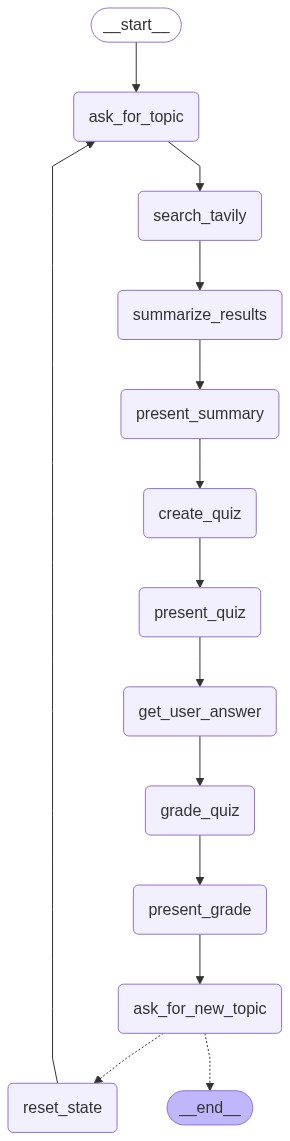

In [14]:
from IPython.display import Image, display
display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)